# Air (Ine)quality in America

Who breathes dirty air in America and where are they located? This project explores the problem of inequality in air quality in America using unsupervised learning. Specifically this project seeks to gain insight into whether or not counties with similar air quality share other similar socio-economic characteristics using K-means clustering. After determining the number of clusters, I use the Python `plotly` library to create a colormaped representation of where counties in each of these clusters are located to offer further insight into their geographic characteristics. 

To conduct this analysis I collected data from the US Environmental Projection Agency (EPA), Census Bureau and Department of Agriculture (USDA). 

While my data set includes a number of variables, including county name and FIPS code, the substanitive variables are ultimately limited to:
1. `Median_AQI`: Air quality index (AQI) measures air pollutant concentrations over a specified averaging period, in this case the entire year of 2018. AQI ranges from 0 to 300+ with categories Good, Moderate, Unhealthy for Sensitive Groups, Unhealthy, Very Unhealthy, Hazardous. For more info: https://www.airnow.gov/aqi/aqi-basics/
2. `percent_Good_Days`: Percent of days that AQI is categorized as "Good" (less than 50). 
3. `PCTPOVALL_2018`: Estimated percent of people of all ages in poverty, 2018
4. `Unemployment_rate_2018`: Unemployment rate, 2018
5. `Median_Household_Income_2018`: Note that the national average is $61,937
6. `RHI825213`: White alone, not Hispanic or Latino, percent, 2013
7. `POP060210`: Population per square mile, 2010

In [1]:
# import modules 
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import silhouette_score

%matplotlib inline
import seaborn as sns

import json
import plotly.express as px

In [2]:
# load data
annual_AQI_2018 = pd.read_csv("../final_project/final_project_data/annual_aqi_by_county_2018.csv")
povertyData = pd.read_csv("../final_project/final_project_data/PovertyEstimates.csv")
unemploymentData = pd.read_csv("../final_project/final_project_data/Unemployment.csv")
census_2010 = pd.read_csv("../final_project/final_project_data/census_2010.txt")

In [3]:
# basic cleaning and formatting 
annual_AQI_2018.columns = annual_AQI_2018.columns.str.replace(" ", "_")

# delete rows that are country of Mexico and US Virgin Islands
not_us_states = ["Country Of Mexico", "Virgin Islands"]
annual_AQI_2018 = pd.DataFrame(annual_AQI_2018[annual_AQI_2018["State"].isin(not_us_states)==False])

# Create a new header for unemploymentData from sixth row and take rest of the data minus header row 
new_header = unemploymentData.iloc[6] 
unemploymentData = unemploymentData[9:] 
unemploymentData.columns = new_header 

# change data types from strings/objects to floats 
unemploymentData.Unemployment_rate_2018 = unemploymentData.Unemployment_rate_2018.astype(float)
unemploymentData.Median_Household_Income_2018 = unemploymentData.Median_Household_Income_2018.str.replace(",", "").astype(float)

To eventually merge these four datasets, it is necessary to re-format the data in columns pertaining to county names, state names, and FIPS county codes. Although the `povertyData`, `unemploymentData` and `census_2010` have FIPS codes which should enable a smooth merge,  `annual_AQI_2018` does not have FIPS codes. Likewise, `povertyData`, `unemploymentData` and  `annual_AQI_2018` have county names but `census_2010` does not. So we need to do a good bit of formatting to make sure that we can pair up the data appropriately and prevent data loss. Also note that the datasets are different sizes, with AQI notably smaller than the others.

In [4]:
print("AQI:", annual_AQI_2018.shape)
print("Poverty Data:", povertyData.shape)
print("Unemployment:", unemploymentData.shape)
print("Census:", census_2010.shape)

AQI: (1051, 19)
Poverty Data: (3193, 34)
Unemployment: (3273, 88)
Census: (3195, 54)


In [5]:
# remove state abbreviations from county names in unemploymentData to enable merge 
states = ["AL", "AK", "AS", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", "GU", "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO",  "MP", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "PR", "RI", "SC", "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
remove = lambda x: " ".join([item for item in x.split() if item not in states])
unemploymentData["area_name"]= unemploymentData.area_name.apply(remove)

# format/ declare county names to enable merge 
annual_AQI_2018.County= annual_AQI_2018.County.str.strip().str.lower() 
povertyData["County"] = povertyData.Area_name
unemploymentData["County"] = unemploymentData.area_name

# edit / remove excess words in county names that impede merge 
to_remove = [",", "County", "county", " City County", "Borough/city", "Borough/municipality", "Borough", "borough", "Census", "census", "Area", "area", "Parish", "parish"]
for x in to_remove:
    povertyData.County = povertyData.County.str.replace(x, "").str.strip().str.lower()
    unemploymentData.County = unemploymentData.County.str.replace(x, "").str.strip().str.lower()

change = ["sainte", "saint"]
for word in change:
    annual_AQI_2018.County = annual_AQI_2018.County.str.replace(word, "st.") 
    
# format FIPS code to enable merge (but keep original to enable pair with map data)
unemploymentData["fips"] = unemploymentData["FIPStxt"].astype(int)
povertyData["fips"] = povertyData["FIPStxt"].astype(int)

# remove rows that are the entire US or entire states 
state_level_fips = range(0, 73000, 1000)
povertyData = pd.DataFrame(povertyData[povertyData["FIPStxt"].isin(state_level_fips) == False])
unemploymentData = pd.DataFrame(unemploymentData[unemploymentData["fips"].isin(state_level_fips) == False])
census_2010 = pd.DataFrame(census_2010[census_2010["fips"].isin(state_level_fips) == False])

In [6]:
# format state names to enable merge 
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

annual_AQI_2018['Stabr'] = annual_AQI_2018.State.replace(us_state_abbrev).str.strip().str.lower()
unemploymentData["Stabr"] = unemploymentData.Stabr.str.strip().str.lower()
povertyData["Stabr"] = povertyData.Stabr.str.strip().str.lower()

In [7]:
# a number of counties have low reporting levels so to make use of Good_Days data create a new column that is % of Good Days/ Number of Days reported
annual_AQI_2018["percent_Good_Days"] = ((annual_AQI_2018.Good_Days / annual_AQI_2018.Days_with_AQI)*100)

Now to select the data we actually want to use and merge the dataFrames. Because `annual_AQI_2018` is so much smaller than the others, I use inner merges. 

In [8]:
# select columns to be used 
annual_AQI_2018 = annual_AQI_2018[["County", "Stabr", "percent_Good_Days", "Median_AQI" ]]
povertyData = povertyData[["County", "Stabr", "PCTPOVALL_2018", "fips"]]
unemploymentData = unemploymentData[["Unemployment_rate_2018", "Median_Household_Income_2018", "FIPStxt", "fips"]]
census_2010 = census_2010[["fips", "RHI825213", "POP060210"]]

#  merge all data 
AQI_pov = pd.merge(annual_AQI_2018, povertyData,  on=["County", "Stabr"], how="inner")
AQI_pov_unemp = pd.merge(AQI_pov, unemploymentData, on=["fips"], how="inner")
combinedData = pd.merge(AQI_pov_unemp, census_2010, on=["fips"], how="inner")
# create a copy of combinedData dataFrame to return to for later mapping 
combinedData_fips = combinedData.copy()

print(combinedData.dtypes)
print("\n CombinedData:", combinedData.shape)

County                           object
Stabr                            object
percent_Good_Days               float64
Median_AQI                        int64
PCTPOVALL_2018                  float64
fips                              int64
Unemployment_rate_2018          float64
Median_Household_Income_2018    float64
FIPStxt                          object
RHI825213                       float64
POP060210                       float64
dtype: object

 CombinedData: (1037, 11)


The original AQI data had 1051 rows, so after all formatting, we managed to only lose 14 counties. 8 of them are from Puerto Rico, which is not represented in `PovertyData` or `unemploymentData`.

Now let's explore what some of the data looks like!

In [9]:
combinedData.describe()

,percent_Good_Days,Median_AQI,PCTPOVALL_2018,fips,Unemployment_rate_2018,Median_Household_Income_2018,RHI825213,POP060210
count,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000,1037.000000
mean,81.343184,34.988428,13.551880,30106.526519,4.135487,58886.734812,74.652170,609.000193
std,14.102801,11.444252,5.051691,15798.324891,1.401452,15834.358543,19.284175,2930.824733
min,9.589041,0.000000,2.600000,1003.000000,1.600000,27859.000000,3.200000,0.100000
25%,75.661376,31.000000,9.900000,17157.000000,3.300000,48409.000000,64.000000,39.500000
50%,84.848485,37.000000,13.000000,30085.000000,3.900000,55358.000000,80.400000,128.200000
75%,90.740741,41.000000,16.300000,42081.000000,4.700000,65883.000000,90.100000,382.300000
max,100.000000,88.000000,37.300000,56045.000000,18.900000,140382.000000,97.800000,69467.500000


In [10]:
combinedData.head()

,County,Stabr,percent_Good_Days,Median_AQI,PCTPOVALL_2018,fips,Unemployment_rate_2018,Median_Household_Income_2018,FIPStxt,RHI825213,POP060210
0,baldwin,al,90.740741,35,9.8,1003,3.6,57588.0,01003,83.1,114.6
1,clay,al,93.636364,27,17.6,1027,3.8,39201.0,01027,80.0,23.1
2,colbert,al,90.613718,35,13.8,1033,4.5,49055.0,01033,78.8,91.8
3,dekalb,al,90.285714,35,21.3,1049,3.8,39491.0,01049,80.7,91.5
4,elmore,al,91.441441,33,11.2,1051,3.4,60367.0,01051,73.9,128.2


Text(0, 0.5, 'County Count')

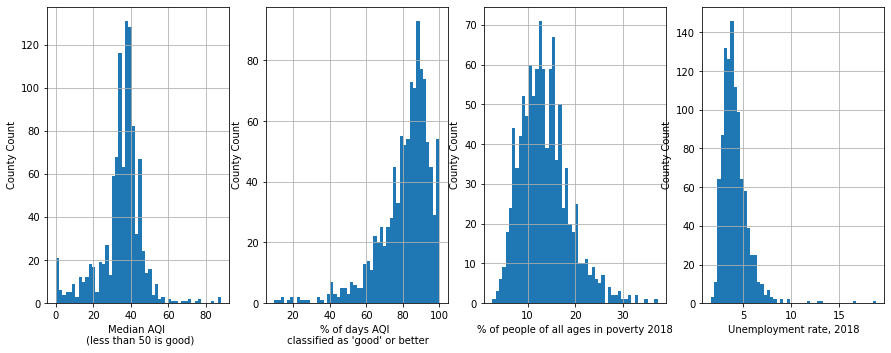

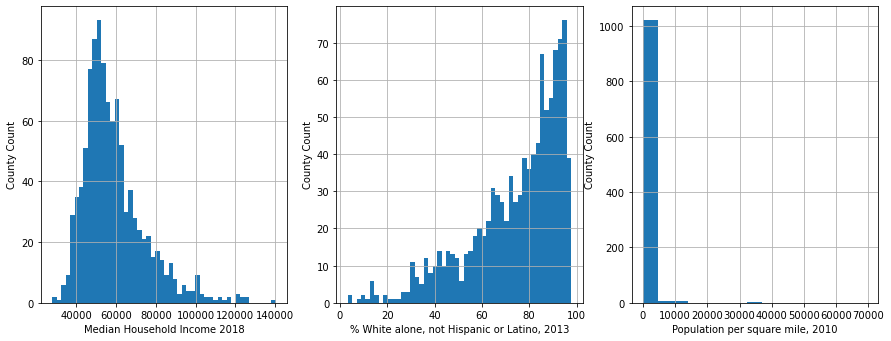

In [11]:
figure = sns.mpl.pyplot.figure(figsize=(15,12))
figure.add_subplot(241)
combinedData.Median_AQI.hist(bins=50)
sns.mpl.pyplot.xlabel("Median AQI \n (less than 50 is good)")
sns.mpl.pyplot.ylabel("County Count")
figure.add_subplot(242)
annual_AQI_2018.percent_Good_Days.hist(bins=50)
sns.mpl.pyplot.xlabel("% of days AQI \n classified as 'good' or better")
sns.mpl.pyplot.ylabel("County Count")
figure.add_subplot(243)
combinedData.PCTPOVALL_2018.hist(bins=50)
sns.mpl.pyplot.xlabel("% of people of all ages in poverty 2018")
sns.mpl.pyplot.ylabel("County Count")
figure.add_subplot(244)
combinedData.Unemployment_rate_2018.hist(bins=50)
sns.mpl.pyplot.xlabel("Unemployment rate, 2018")
sns.mpl.pyplot.ylabel("County Count")

figure2 = sns.mpl.pyplot.figure(figsize=(15,12))
figure2.add_subplot(231)
combinedData.Median_Household_Income_2018.hist(bins=50)
sns.mpl.pyplot.xlabel("Median Household Income 2018")
sns.mpl.pyplot.ylabel("County Count")
figure2.add_subplot(232)
combinedData.RHI825213.hist(bins=50)
sns.mpl.pyplot.xlabel("% White alone, not Hispanic or Latino, 2013")
sns.mpl.pyplot.ylabel("County Count")
figure2.add_subplot(233)
combinedData.POP060210.hist(bins=15)
sns.mpl.pyplot.xlabel("Population per square mile, 2010")
sns.mpl.pyplot.ylabel("County Count")



Text(0, 0.5, 'AQI')

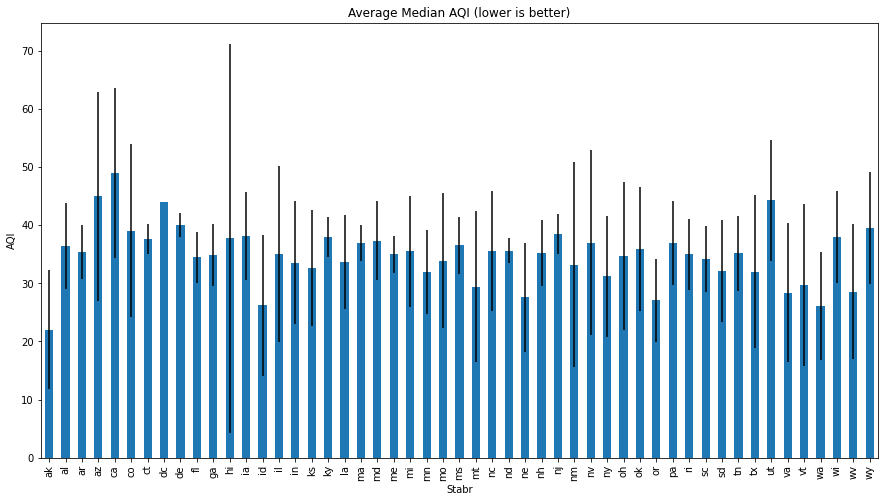

In [12]:
errs = combinedData.groupby("Stabr")["Median_AQI"].agg(np.std)
combinedData.groupby("Stabr")["Median_AQI"].agg(np.mean).plot(yerr = errs,kind='bar', title = "Average Median AQI (lower is better)", figsize=(15,8))
sns.mpl.pyplot.ylabel("AQI")

Text(0, 0.5, '% Good Days')

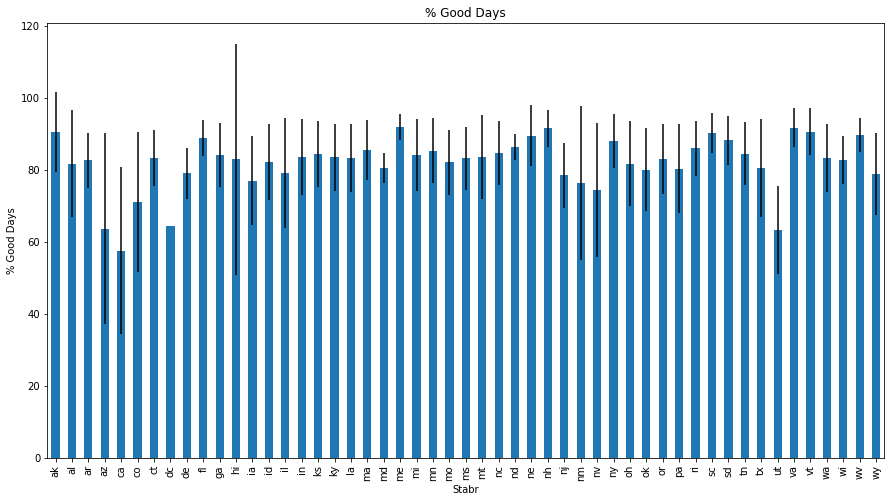

In [13]:
errs = combinedData.groupby("Stabr")["percent_Good_Days"].agg(np.std)
combinedData.groupby("Stabr")["percent_Good_Days"].agg(np.mean).plot(yerr = errs,kind='bar', title = "% Good Days", figsize=(15,8))
sns.mpl.pyplot.ylabel("% Good Days")

This bit of exploratory analysis suggests that the worst air quality can be found in California, Arizona, Utah, D.C. -- Hawaii is notable for its level of variance. However this is all state-level analysis and we are interested in county-by-county patterns.

Onto the K-means clustering.

In [14]:
combinedData = combinedData[["Median_AQI", "percent_Good_Days", "PCTPOVALL_2018", "Unemployment_rate_2018", "Median_Household_Income_2018", "RHI825213", "POP060210"]]
combinedData_features = combinedData.columns

In [15]:
# scale and center the data
scaler = StandardScaler()
combinedData_scaled = scaler.fit_transform(combinedData[combinedData_features])
combinedData_scaled = pd.DataFrame(combinedData_scaled, columns = combinedData_features)
print("Before scaling:\n", combinedData[combinedData_features].describe())
print("\nAfter scaling:\n", np.round(combinedData_scaled.describe(),2))

Before scaling:
         Median_AQI  percent_Good_Days  PCTPOVALL_2018  Unemployment_rate_2018  \
count  1037.000000        1037.000000     1037.000000             1037.000000   
mean     34.988428          81.343184       13.551880                4.135487   
std      11.444252          14.102801        5.051691                1.401452   
min       0.000000           9.589041        2.600000                1.600000   
25%      31.000000          75.661376        9.900000                3.300000   
50%      37.000000          84.848485       13.000000                3.900000   
75%      41.000000          90.740741       16.300000                4.700000   
max      88.000000         100.000000       37.300000               18.900000   

       Median_Household_Income_2018    RHI825213     POP060210  
count                   1037.000000  1037.000000   1037.000000  
mean                   58886.734812    74.652170    609.000193  
std                    15834.358543    19.284175   2930.82

Text(0, 0.5, 'silhouette score')

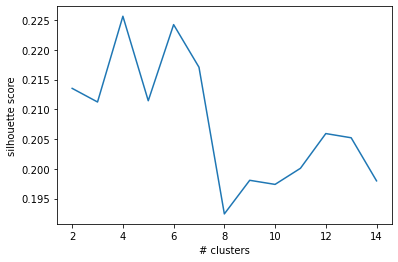

In [16]:
silhouette_scores = []
for cluster in range(2,15):
    km = KMeans(n_clusters=cluster).fit(combinedData_scaled)
    silhouette_scores.append(silhouette_score(combinedData_scaled, km.labels_))
sns.mpl.pyplot.plot(range(2,15), silhouette_scores)
sns.mpl.pyplot.xlabel("# clusters")
sns.mpl.pyplot.ylabel("silhouette score")

To determine the number of clusters to use, I rely not only on this chart of silhouette scores but also compare what different clustering models look like on a geographic visualization below (more on that later). I ultimately decide to go with 8 clusters. 

In [17]:
# create clusters 
km8 = KMeans(n_clusters=8,random_state=1234)
km8.fit(combinedData_scaled)
combinedData['kmeans_8_scaled'] = [ "cluster_" + str(label) for label in km8.labels_ ]

# add cluster labels to copy of combinedData with fips codes to enable mapping 
combinedData_fips['kmeans_8_scaled'] = [ "cluster_" + str(label) for label in km8.labels_ ]

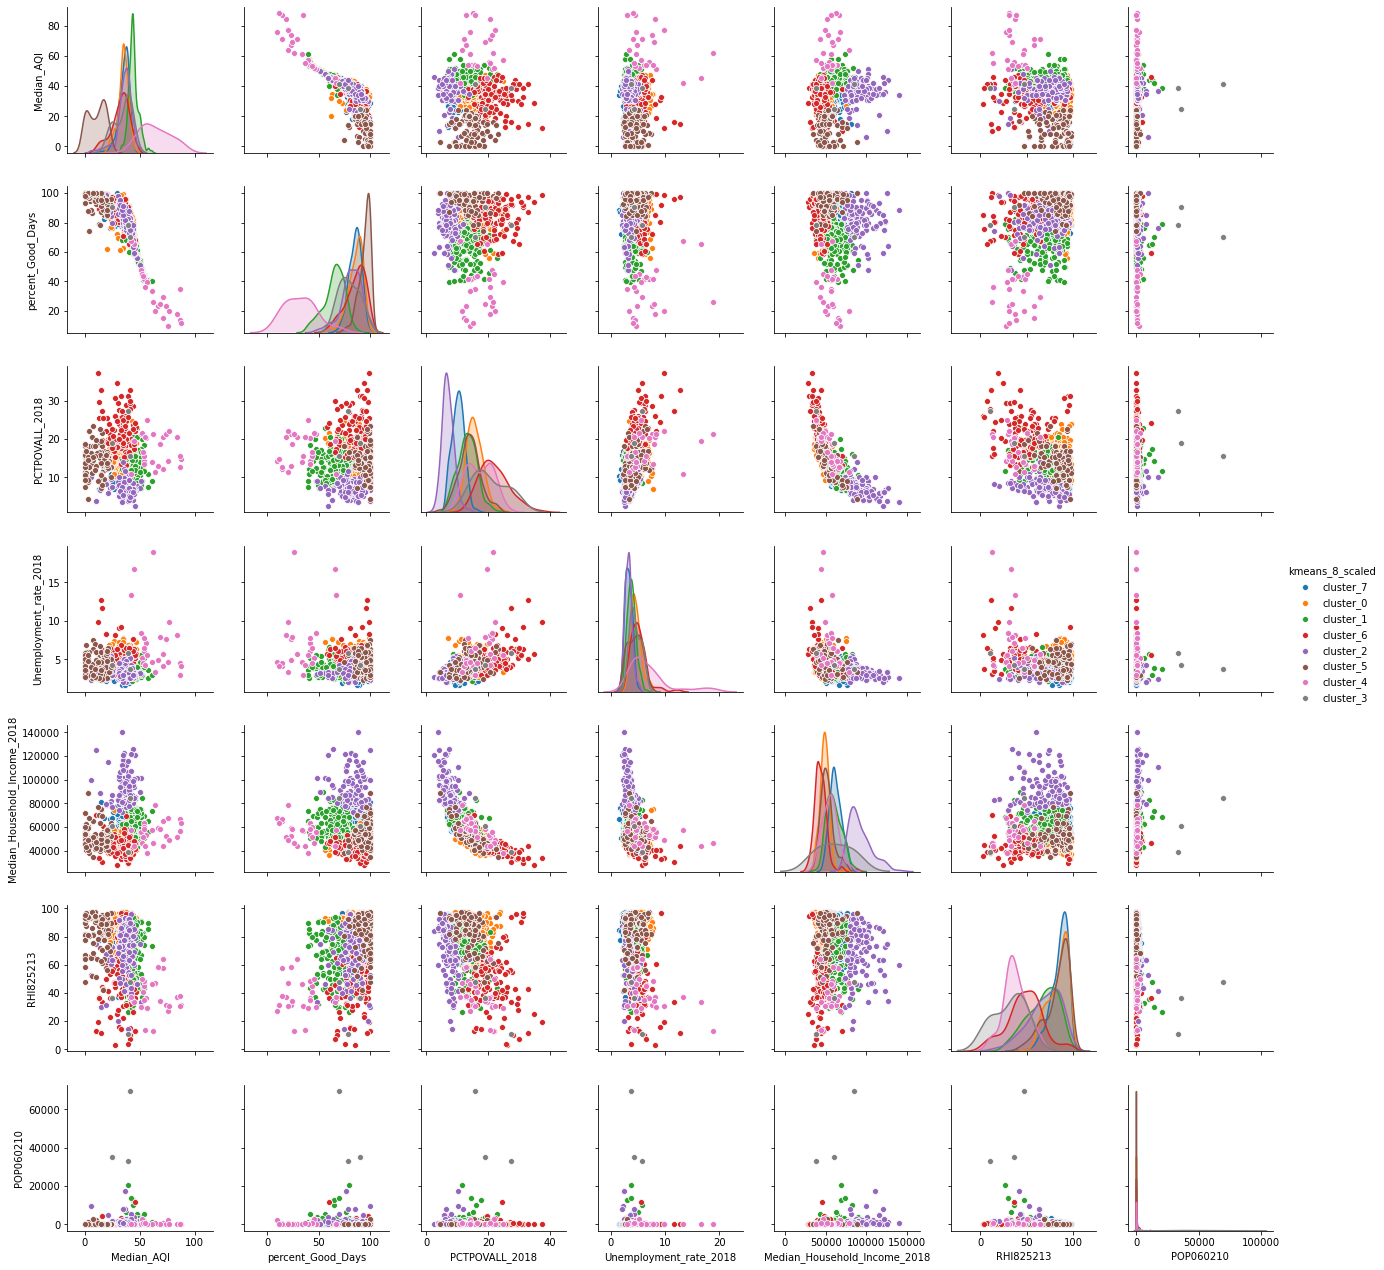

In [18]:
sns.pairplot(combinedData,hue="kmeans_8_scaled")

In [19]:
combinedData.kmeans_8_scaled.value_counts()

cluster_7    264
cluster_0    248
cluster_1    170
cluster_6    115
cluster_2    112
cluster_5    100
cluster_4     25
cluster_3      3
Name: kmeans_8_scaled, dtype: int64

In [20]:
combinedData.groupby('kmeans_8_scaled').mean().round(2)

,Median_AQI,percent_Good_Days,PCTPOVALL_2018,Unemployment_rate_2018,Median_Household_Income_2018,RHI825213,POP060210
kmeans_8_scaled,,,,,,,
cluster_0,35.04,85.41,15.63,4.67,48786.45,83.76,147.02
cluster_1,44.49,65.14,13.25,3.88,60572.29,67.33,1085.90
cluster_2,36.10,81.77,7.01,3.28,92397.17,69.34,1232.99
cluster_3,35.00,79.54,20.60,4.60,61346.00,31.33,45913.40
cluster_4,64.44,32.60,17.26,7.06,55520.92,37.81,419.80
cluster_5,11.11,94.74,14.02,4.45,52255.42,83.16,121.70
cluster_6,32.38,85.61,21.97,5.17,43646.54,48.37,403.95
cluster_7,35.74,85.48,10.30,3.31,62514.30,85.27,248.17


### Description of notable clusters
The cluster with the worst air quality is `cluster_4`. On average, only about a third of the days in the year can be said to have "good" air quality, it is also the cluster with the second lowest average percent white population (second only to `cluster_3`  which is basically just New York City), it is only 38% white while the national average is 74% white (at least it was in 2013). `cluster_4` also has a higher unemployment rate (7%) than the national average (4%), a higher poverty rate (17.26%) than the national average (13.5%) and relatively low population density.

Interestingly, its median household income is quite similar to the cluster with the best air quality, `cluster_5` - both of which are below the national average, however `cluster_5` is 83% white compared to 38% white in `cluster_4`, additionally, `cluster_5` has the lowest population density. 

`cluster_1` has the second worst air quality, however, whereas only one third of the days in the year in `cluster_4` qualify as good, in `cluster_1`, two-thirds of days do, this suggest different underlying patterns and causes of air pollution. `cluster_1` also has a much higher population density on average, a higher average household income and is 67% white. 

In [24]:
import plotly.io as pio

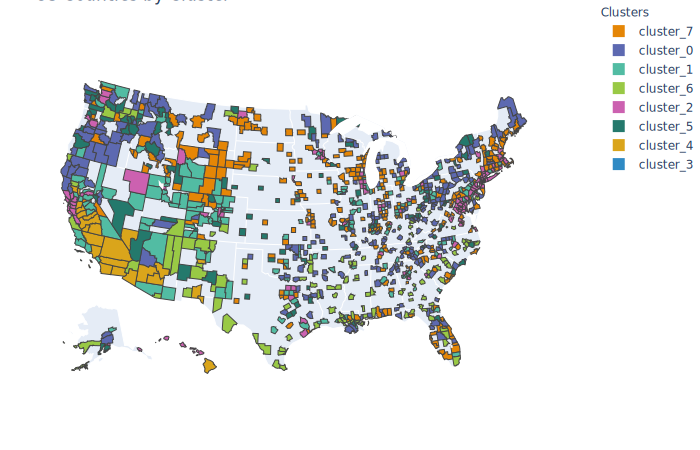

In [23]:
df = combinedData_fips
df["fips"] = df.FIPStxt.astype(str)


from urllib.request import urlopen
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

fig = px.choropleth(df, geojson=counties, locations='fips', color='kmeans_8_scaled',
                    hover_name = "County", 
                    hover_data = ["Median_AQI", "PCTPOVALL_2018", "percent_Good_Days", "Unemployment_rate_2018", "Median_Household_Income_2018", "RHI825213", "POP060210"],
                    color_discrete_sequence=px.colors.qualitative.Vivid,
                    scope="usa",
                    labels={'kmeans_8_scaled':'Clusters'},
                          )
fig.update_layout(title_text = "US Counties by Cluster", margin={"r":0,"t":1,"l":0,"b":0})
fig.show(renderer="svg")

## Concluding thoughts
Clearly there are many counties which do not supply air quality data to the EPA, so our picture of US air (ine)quality is quite literally incomplete.

Nevertheless, creating this geographic visualization provided a useful sanity check while determining the appropriate number of clusters (e.g. NYC counties should not be clustered with counties in rural Colorado).

This visualization also helps further identify that the areas of the country with the worst air quality are in Southern California/ California's Central Valley, New Mexico, Arizona and Hawaii (note however that no counties in Utah or DC made it into this cluster despite having some of the worst air nationally). Although we had a sense of this from earlier data exploration, we are able to get a better sense of the variation within states. 

Ultimately I believe we do find that US counties can be segmented in meaningful ways based on their air quality and socio-economic characeristics, with race being a particularlly notable distinction between the counties with the best and worst air quality in the country. However, since two-thirds of US counties do not currently provide the EPA with air quality data, future research would benefit from greater availablity of data. 